In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from functools import partial
import re


# Parsing raw data
After interpreting the data structure of the raw files (available [here](https://archive.ics.uci.edu/ml/datasets/Heart+Disease)) and performing minor changes to the files (such as removing corrupted rows from `cleveland.data`), the following cells parse the files and schema, and generate a dataframe accordingly.

In [3]:
def read_datafile(path):
    """
    Description:
        Reads and parses this dataset's `.data` files. Uses regular expression matching to identify the last column (containing the patient's name)
        in case of file corruption, parsing is interrupted and the function returns the partial data gathered up to that point.
        
    Arguments:
        path : path to the `.data` file.

    Returns:
        out_df : pd.DataFrame containing all the parsed lines information.
    """
    with open(path, 'r') as src:
        print(f'parsing {path}')
        parsed_line = []
        parsed_lines = []
        for line in src:
            try :
                parts = line.strip().split(' ')

                if re.match('[^\W\d_]', parts[-1]):
                    # Name of the patient denotes the end of a row
                    parsed_line += parts
                    parsed_line += [Path(path).stem]
                    parsed_lines.append(parsed_line)
                    parsed_line = []
                
                else:
                    parsed_line += parts

            except Exception as e:
                print(f'Error parsing {path}. Returning partial dataframe.')
                break
    
    out_df = pd.DataFrame(parsed_lines)
    return out_df

In [4]:
# Parse all .data files available in the original dataset

datapaths = list(Path('data/raw').glob('*.data'))
dfs = []
for path in datapaths:
    try:
        dfs.append(read_datafile(path))
    except Exception as e:
        print(f'Error parsing "{path}" : {e}')

parsing data\raw\cleveland.data
Error parsing "data\raw\cleveland.data" : 'charmap' codec can't decode byte 0x8d in position 1489: character maps to <undefined>
parsing data\raw\cleveland_minus_corrupted.data
parsing data\raw\hungarian.data
parsing data\raw\long-beach-va.data
parsing data\raw\switzerland.data


In [5]:
# Parsing and composing a schema dictionary from the data schema

with open('data/raw/schema.txt', 'r') as src:
    schema = {}
    desc = {}
    current_col = 0
    for line in src:
        parts = line.split(' ')
        try:
            current_col = int(parts[0]) - 1
            schema[current_col] = parts[1].strip(':').strip()
            desc[schema[current_col]] = ' '.join(parts[1:])
        except:
            desc[schema[current_col]] += line 


In [6]:
desc

{'id': 'id: patient identification number\n',
 'ssn': 'ssn: social security number (I replaced this with a dummy value of 0)\n',
 'age': 'age: age in years\n',
 'sex': 'sex: sex (1 = male; 0 = female)\n',
 'cp_substernal': 'cp_substernal: chest pain location (1 = substernal; 0 = otherwise)\n',
 'cp_exertion': 'cp_exertion (1 = provoked by exertion; 0 = otherwise)\n',
 'cp_rest_relieve': 'cp_rest_relieve (1 = relieved after rest; 0 = otherwise)\n',
 'pncaden': 'pncaden (sum of 5, 6, and 7)\n',
 'cp_type': 'cp_type: chest pain type\n-- Typical angina pectoris. Pain that occurs in the anterior thorax, neck, shoulders, jaw, or arms is precipitated by exertion and relieved within 20 min by rest.\n-- Atypical angina. Pain in one of the above locations and either not precipitated by exertion or not relieved by rest within 20 min.\n-- Nonanginal pain. Pain not located in any of the above locations, or if so located not related to exertion, and lasting less than 10 sec or longer than 30 min.\n-

In [7]:
# Checking the parsed dataframes shapes
for df in dfs:
    print(df.shape)

(282, 77)
(294, 77)
(200, 77)
(123, 77)


In [8]:
df = pd.concat(dfs)
df.columns = [v for k, v in schema.items()] + ['source']
df = df.replace({'?': None, '-9': None})

for col in df.columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        continue

# Inspecting the distribution of unused columns or columns with descriptions missing and subsequently dropping these columns from the dataframe
unused_cols = ['ssn', 'name', 'junk', 'cathef', 'lvf', 'lvx4', 'lvx3', 'lvx2', 'lvx1',  'earlobe', 'thalpul', 'thalsev', 'exerckm', 'restckm']

no_desc_cols = ['rcadist', 'rcaprox', 'om1', 'om2', 'ramus', 'cxmain', 'diag', 'laddist', 'ladprox', 'lmt', 'htn', 'dummy']

In [9]:
df = df.drop(unused_cols + no_desc_cols, axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 899 entries, 0 to 122
Data columns (total 51 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     899 non-null    int64  
 1   age                    899 non-null    int64  
 2   sex                    899 non-null    int64  
 3   cp_substernal          617 non-null    float64
 4   cp_exertion            617 non-null    float64
 5   cp_rest_relieve        613 non-null    float64
 6   pncaden                0 non-null      float64
 7   cp_type                899 non-null    int64  
 8   blood_press_s_rest     840 non-null    float64
 9   chol                   869 non-null    float64
 10  smoker                 230 non-null    float64
 11  smoker_cigs_per_day    479 non-null    float64
 12  smoker_years           467 non-null    float64
 13  fasting_blood_sugar    809 non-null    float64
 14  diabetes               95 non-null     float64
 15  heart_

# Categorial remapping and date interpretation

In [10]:
df.groupby('source').smoker.value_counts()

source         smoker
hungarian      0.0       10
               1.0        2
long-beach-va  1.0       99
               0.0       96
switzerland    1.0       18
               0.0        5
Name: smoker, dtype: int64

In [11]:
def remap_categoricals(dataframe):
    """
    Description:
        This function concentrates all the variable remappings according to the data schema. 

    Arguments:
        dataframe : input dataframe acquired after parsing

    Returns:
        df : processed dataframe with remapped columns
    """

    df = dataframe.copy()
    df['sex'] = df.sex.replace({0: 'F', 1: 'M'})
    df['cp_substernal'] = df.cp_substernal.replace({1: 'yes', 0: 'no'})
    df['cp_exertion'] = df.cp_exertion.replace({1: 'yes', 0: 'no'})
    df['cp_rest_relieve'] = df.cp_rest_relieve.replace({1: 'yes', 0: 'no'})
    df['cp_type'] = df.cp_type.replace({1: 'typical_angina', 2: 'atypical_angina', 3: 'non_anginal', 4: 'no_pain'})

    df['smoker'] = df.smoker.replace({1: 'yes', 0: 'no'})
    df['diabetes'] = df.diabetes.replace({1: 'yes', 0: 'no'})
    df['heart_disease_family'] = df.heart_disease_family.replace({1: 'yes', 0: 'no'})
    df['rest_ecg'] = df.rest_ecg.replace({0: 'normal', 1: 'st-t_abnormal', 2: 'hypertrophy'})
    # {
    df['digitalis_used'] = df.digitalis_used.replace({1: 'yes', 0: 'no'})
    df['betablocker_used'] = df.betablocker_used.replace({1: 'yes', 0: 'no', 22.0: None})
    df['nitrate_used'] = df.nitrate_used.replace({1: 'yes', 0: 'no'})
    df['ccblocker_used'] = df.ccblocker_used.replace({1: 'yes', 0: 'no'})
    df['diuretic_used'] = df.diuretic_used.replace({1: 'yes', 0: 'no'})
    # } are these relevant?

    df['ex_protocol'] = df.ex_protocol.replace({1: 'bruce', 2: 'kottus', 3: 'mchenry',
                                                4: 'fast_balke', 5: 'balke', 6: 'noughton',
                                                7: 'bike_150', 8: 'bike_125', 9: 'bike_100',
                                               10: 'bike_75', 11: 'bike_50', 12: 'arm_ergometer'}) # Check protocols (can the bike ones be ordinal/numeric?)
    df['ex_angina'] = df.ex_angina.replace({1: 'yes', 0: 'no'})
    df['ex_hypotension'] = df.ex_hypotension.replace({1: 'yes', 0: 'no'}) # What is this?
    df['st_slope_peak'] = df.st_slope_peak.replace({1: 'up', 2: 'flat', 3: 'down', 0: None})
    df['wm_abnormal_rest'] = df.wm_abnormal_rest.replace({0: 'normal', 1: 'moderate', 2: 'severe', 3: 'akinesis_or_dyskmem'}) # dafuq is this
    df['wm_abnormal_ex'] = df.wm_abnormal_ex.replace({1: 'yes', 0: 'no'})
    
    # Remapping and removing non standard values
    df['thalium_stress_result'] = df.thalium_stress_result.replace({0: None, 1: None, 2: None, 3: 'normal', 4: None,
                                                                    5: None, 6: 'fixed_defect', 7:'reversible'})

    df['chol'] = df.chol.replace({0.0: None})

    return df
    

def parse_date(row, prefix='ekg'):
        """Auxiliary function for date parsing"""
        try:
            out = pd.to_datetime("19{:02d}-{:02d}-{:02d}".format(int(row[prefix+'yr']), int(row[prefix+'mo']), int(row[prefix+'day'])))
        except:
            out = None
        return out


def parse_date_cols(dataframe):
    """
    Description:
        parses date columns in the dataframe and drops day/month/year columns for each
        of the two date features, replacing those by string dates in the format YYYY-MM-DD

    Arguments:
        dataframe : input dataframe

    Returns:
        df : processed dataframe after date parsing
    """

    df = dataframe.copy()
    
    df['ekg_date'] = df.apply(partial(parse_date, prefix='ekg'), axis=1)
    df['angiogram_date'] = df.apply(partial(parse_date, prefix='c'), axis=1)
    
    df = df.drop(['ekgday', 'ekgmo', 'ekgyr', 'cday', 'cmo', 'cyr'], axis=1)
    return df

df = remap_categoricals(df)
df = parse_date_cols(df)
df

,id,age,sex,cp_substernal,cp_exertion,cp_rest_relieve,pncaden,cp_type,blood_press_s_rest,chol,...,vessels_colored,ejection_frac_rest,wm_abnormal_rest,ejection_frac_ex,wm_abnormal_ex,thalium_stress_result,cad,source,ekg_date,angiogram_date
0,1,63,M,NaN,NaN,NaN,NaN,typical_angina,145.0,233.0,...,0.0,NaN,NaN,NaN,NaN,fixed_defect,0,cleveland_minus_corrupted,1981-02-03,1981-02-16
1,2,67,M,NaN,NaN,NaN,NaN,no_pain,160.0,286.0,...,3.0,NaN,NaN,NaN,NaN,normal,2,cleveland_minus_corrupted,1981-03-05,1981-02-05
2,3,67,M,NaN,NaN,NaN,NaN,no_pain,120.0,229.0,...,2.0,NaN,NaN,NaN,NaN,reversible,1,cleveland_minus_corrupted,1981-02-19,1981-02-20
3,4,37,M,NaN,NaN,NaN,NaN,non_anginal,130.0,250.0,...,0.0,NaN,NaN,NaN,NaN,normal,0,cleveland_minus_corrupted,1981-02-13,1981-02-04
4,6,41,F,NaN,NaN,NaN,NaN,atypical_angina,130.0,204.0,...,0.0,NaN,NaN,NaN,NaN,normal,0,cleveland_minus_corrupted,1981-02-07,1981-02-18
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,4070,54,M,yes,yes,yes,NaN,no_pain,180.0,None,...,NaN,NaN,NaN,NaN,NaN,reversible,1,switzerland,1985-05-06,1985-05-07
119,4071,56,M,yes,yes,yes,NaN,no_pain,125.0,None,...,NaN,NaN,NaN,NaN,NaN,reversible,3,switzerland,1985-06-19,1985-06-20
120,4072,56,M,no,yes,yes,NaN,non_anginal,125.0,None,...,NaN,NaN,NaN,NaN,NaN,reversible,2,switzerland,1985-06-24,1985-06-25
121,4073,54,M,yes,yes,yes,NaN,no_pain,130.0,None,...,NaN,NaN,NaN,NaN,NaN,reversible,3,switzerland,1985-07-03,1985-07-04


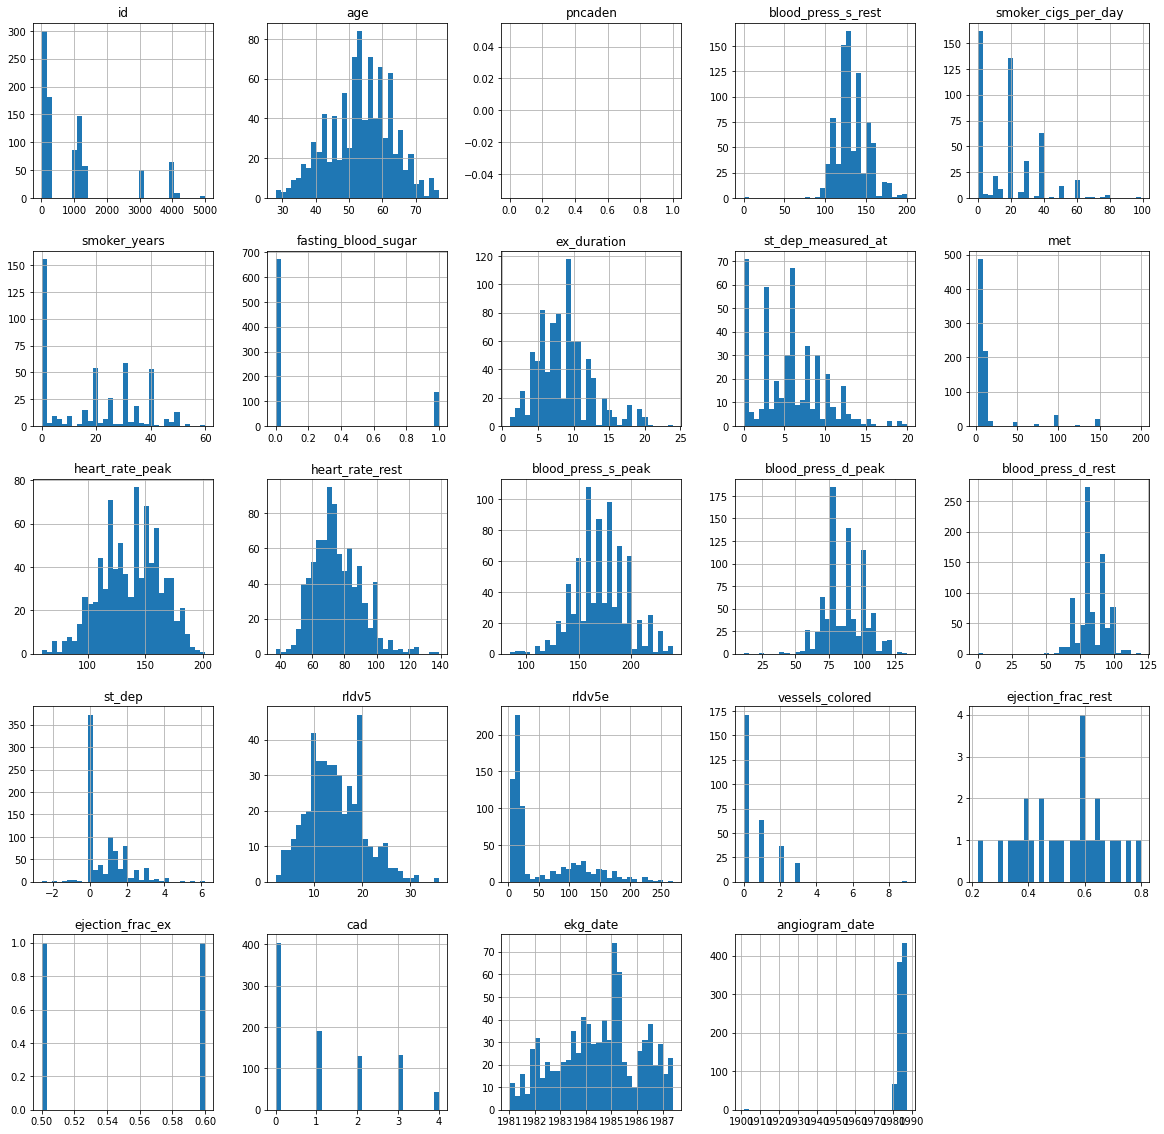

In [18]:
# Histograms to assess general data distributions
df.hist(figsize=(20, 20), bins=32);

The `rldv5e` feature distribution seems odd, as if there were two normal distributions with different variances overlapped. We'll investigate further in the next notebook.

In [12]:
# Save the parsed and remapped dataset
df.to_csv('data/processed/heart_risk.csv', index=None)